In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
def get_data_old(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    
    zero_padding = tf.zeros([10000000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [7]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(100)
    return output_ds

In [8]:
size_sec = 30
stride_sec = 1

In [9]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [10]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)


(30, 257, 1)
tf.Tensor(23, shape=(), dtype=int64)


In [11]:
batch_size = 128
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [12]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
    
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(1)
])

model.summary()

Input shape: (30, 257, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 257)           0         
_________________________________________________________________
normalization (Normalization (None, 30, 257)           3         
_________________________________________________________________
dense (Dense)                (None, 30, 256)           66048     
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

In [14]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 1806.5590 - mse: 1806.5590 - val_loss: 1831.3893 - val_mse: 1831.3893
Epoch 2/10000
1/1 [==============================] - 0s 143ms/step - loss: 977.9045 - mse: 977.9045 - val_loss: 5272.5054 - val_mse: 5272.5054
Epoch 3/10000
1/1 [==============================] - 0s 143ms/step - loss: 603.3000 - mse: 603.3000 - val_loss: 805.1472 - val_mse: 805.1472
Epoch 4/10000
1/1 [==============================] - 0s 141ms/step - loss: 677.1946 - mse: 677.1946 - val_loss: 839.1245 - val_mse: 839.1245
Epoch 5/10000
1/1 [==============================] - 0s 141ms/step - loss: 605.1604 - mse: 605.1604 - val_loss: 747.4308 - val_mse: 747.4308
Epoch 6/10000
1/1 [==============================] - 0s 144ms/step - loss: 593.2695 - mse: 593.2695 - val_loss: 754.1369 - val_mse: 754.1369
Epoch 7/10000
1/1 [==============================] - 0s 143ms/step - loss: 570.6824 - mse: 570.6824 - val_loss: 882.0496 - val_mse: 882.0496
Epoch 8/10

1/1 [==============================] - 0s 141ms/step - loss: 134.0128 - mse: 134.0128 - val_loss: 248.3170 - val_mse: 248.3170
Epoch 59/10000
1/1 [==============================] - 0s 141ms/step - loss: 148.1712 - mse: 148.1712 - val_loss: 84.2658 - val_mse: 84.2658
Epoch 60/10000
1/1 [==============================] - 0s 144ms/step - loss: 129.2546 - mse: 129.2546 - val_loss: 62.4549 - val_mse: 62.4549
Epoch 61/10000
1/1 [==============================] - 0s 146ms/step - loss: 129.9024 - mse: 129.9024 - val_loss: 60.7061 - val_mse: 60.7061
Epoch 62/10000
1/1 [==============================] - 0s 144ms/step - loss: 155.1256 - mse: 155.1256 - val_loss: 62.0051 - val_mse: 62.0051
Epoch 63/10000
1/1 [==============================] - 0s 146ms/step - loss: 92.9201 - mse: 92.9201 - val_loss: 71.2846 - val_mse: 71.2846
Epoch 64/10000
1/1 [==============================] - 0s 143ms/step - loss: 118.6596 - mse: 118.6596 - val_loss: 69.4856 - val_mse: 69.4856
Epoch 65/10000
1/1 [===============

Epoch 117/10000
1/1 [==============================] - 0s 143ms/step - loss: 73.5838 - mse: 73.5838 - val_loss: 51.9054 - val_mse: 51.9054
Epoch 118/10000
1/1 [==============================] - 0s 145ms/step - loss: 69.5926 - mse: 69.5926 - val_loss: 54.7958 - val_mse: 54.7958
Epoch 119/10000
1/1 [==============================] - 0s 144ms/step - loss: 75.9070 - mse: 75.9070 - val_loss: 60.8076 - val_mse: 60.8076
Epoch 120/10000
1/1 [==============================] - 0s 142ms/step - loss: 73.0712 - mse: 73.0712 - val_loss: 57.6791 - val_mse: 57.6791
Epoch 121/10000
1/1 [==============================] - 0s 145ms/step - loss: 49.2337 - mse: 49.2337 - val_loss: 47.3005 - val_mse: 47.3005
Epoch 122/10000
1/1 [==============================] - 0s 142ms/step - loss: 75.4140 - mse: 75.4140 - val_loss: 44.4607 - val_mse: 44.4607
Epoch 123/10000
1/1 [==============================] - 0s 139ms/step - loss: 48.5725 - mse: 48.5725 - val_loss: 48.1692 - val_mse: 48.1692
Epoch 124/10000
1/1 [======

Epoch 176/10000
1/1 [==============================] - 0s 148ms/step - loss: 52.3679 - mse: 52.3679 - val_loss: 36.7406 - val_mse: 36.7406
Epoch 177/10000
1/1 [==============================] - 0s 157ms/step - loss: 49.9984 - mse: 49.9984 - val_loss: 44.4797 - val_mse: 44.4797
Epoch 178/10000
1/1 [==============================] - 0s 150ms/step - loss: 55.6345 - mse: 55.6345 - val_loss: 43.2255 - val_mse: 43.2255
Epoch 179/10000
1/1 [==============================] - 0s 153ms/step - loss: 49.0404 - mse: 49.0404 - val_loss: 40.9546 - val_mse: 40.9546
Epoch 180/10000
1/1 [==============================] - 0s 152ms/step - loss: 58.6934 - mse: 58.6934 - val_loss: 37.0942 - val_mse: 37.0942
Epoch 181/10000
1/1 [==============================] - 0s 149ms/step - loss: 53.0753 - mse: 53.0753 - val_loss: 31.0710 - val_mse: 31.0710
Epoch 182/10000
1/1 [==============================] - 0s 148ms/step - loss: 47.0900 - mse: 47.0900 - val_loss: 30.5392 - val_mse: 30.5392
Epoch 183/10000
1/1 [======

Epoch 235/10000
1/1 [==============================] - 0s 146ms/step - loss: 50.7191 - mse: 50.7191 - val_loss: 40.4092 - val_mse: 40.4092
Epoch 236/10000
1/1 [==============================] - 0s 147ms/step - loss: 47.0159 - mse: 47.0159 - val_loss: 40.8081 - val_mse: 40.8081
Epoch 237/10000
1/1 [==============================] - 0s 145ms/step - loss: 41.4106 - mse: 41.4106 - val_loss: 52.2223 - val_mse: 52.2223
Epoch 238/10000
1/1 [==============================] - 0s 264ms/step - loss: 37.9805 - mse: 37.9805 - val_loss: 53.8499 - val_mse: 53.8499
Epoch 239/10000
1/1 [==============================] - 0s 144ms/step - loss: 40.5069 - mse: 40.5069 - val_loss: 42.4933 - val_mse: 42.4933
Epoch 240/10000
1/1 [==============================] - 0s 149ms/step - loss: 45.2617 - mse: 45.2617 - val_loss: 35.8195 - val_mse: 35.8195
Epoch 241/10000
1/1 [==============================] - 0s 144ms/step - loss: 57.7892 - mse: 57.7892 - val_loss: 36.4547 - val_mse: 36.4547
Epoch 242/10000
1/1 [======

Epoch 294/10000
1/1 [==============================] - 0s 146ms/step - loss: 45.3321 - mse: 45.3321 - val_loss: 41.5195 - val_mse: 41.5195
Epoch 295/10000
1/1 [==============================] - 0s 142ms/step - loss: 19.8541 - mse: 19.8541 - val_loss: 51.4223 - val_mse: 51.4223
Epoch 296/10000
1/1 [==============================] - 0s 137ms/step - loss: 31.1072 - mse: 31.1072 - val_loss: 48.8027 - val_mse: 48.8027
Epoch 297/10000
1/1 [==============================] - 0s 138ms/step - loss: 31.1729 - mse: 31.1729 - val_loss: 44.0006 - val_mse: 44.0006
Epoch 298/10000
1/1 [==============================] - 0s 142ms/step - loss: 34.0155 - mse: 34.0155 - val_loss: 45.3924 - val_mse: 45.3924
Epoch 299/10000
1/1 [==============================] - 0s 141ms/step - loss: 36.7684 - mse: 36.7684 - val_loss: 52.8625 - val_mse: 52.8625
Epoch 300/10000
1/1 [==============================] - 0s 142ms/step - loss: 30.7253 - mse: 30.7253 - val_loss: 52.3921 - val_mse: 52.3921
Epoch 301/10000
1/1 [======

1/1 [==============================] - 0s 140ms/step - loss: 25.7377 - mse: 25.7377 - val_loss: 58.5733 - val_mse: 58.5733
Epoch 353/10000
1/1 [==============================] - 0s 141ms/step - loss: 36.5271 - mse: 36.5271 - val_loss: 47.0515 - val_mse: 47.0515
Epoch 354/10000
1/1 [==============================] - 0s 141ms/step - loss: 30.6031 - mse: 30.6031 - val_loss: 41.1741 - val_mse: 41.1741
Epoch 355/10000
1/1 [==============================] - 0s 143ms/step - loss: 37.6228 - mse: 37.6228 - val_loss: 40.7739 - val_mse: 40.7739
Epoch 356/10000
1/1 [==============================] - 0s 136ms/step - loss: 27.1459 - mse: 27.1459 - val_loss: 46.5650 - val_mse: 46.5650
Epoch 357/10000
1/1 [==============================] - 0s 139ms/step - loss: 19.4453 - mse: 19.4453 - val_loss: 70.4044 - val_mse: 70.4044
Epoch 358/10000
1/1 [==============================] - 0s 139ms/step - loss: 42.0220 - mse: 42.0220 - val_loss: 80.4030 - val_mse: 80.4030
Epoch 359/10000
1/1 [======================

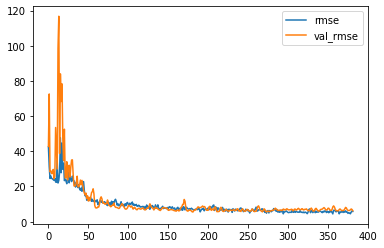

In [15]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [16]:
np.sqrt(model.evaluate(val_ds.batch(batch_size)))

1/1 [==============================] - 0s 83ms/step - loss: 38.7590 - mse: 38.7590


array([6.22567593, 6.22567593])

In [17]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 1s 702ms/step - loss: 70.5698 - mse: 70.5698


array([8.40058112, 8.40058112])

In [18]:
model.predict(preprocess_dataset([train_files[0]]).batch(30), verbose=2)

1/1 - 0s


array([[27.613955]], dtype=float32)

In [19]:
model.predict(get_data(train_files[0])[0])

array([[27.613953],
       [27.926525],
       [28.089151],
       [27.852127],
       [27.772894],
       [27.663982],
       [26.987913],
       [26.662405],
       [26.406897],
       [26.453966],
       [27.014967],
       [27.170177],
       [26.678186],
       [25.764532],
       [25.767687]], dtype=float32)

In [20]:
get_data(train_files[5])[1]

<tf.Tensor: shape=(), dtype=int64, numpy=29>

In [21]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [22]:
meta.predict.describe()

count    108.000000
mean      22.461428
std        4.750969
min        7.978041
25%       19.454902
50%       23.823333
75%       26.175219
max       29.372707
Name: predict, dtype: float64

In [23]:
from sklearn.metrics import confusion_matrix, mean_squared_error
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.896728
1,train,5.046426
2,val,7.598230


In [24]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,5.670140
1,male,5.974397


In [25]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

5.8073335540360045

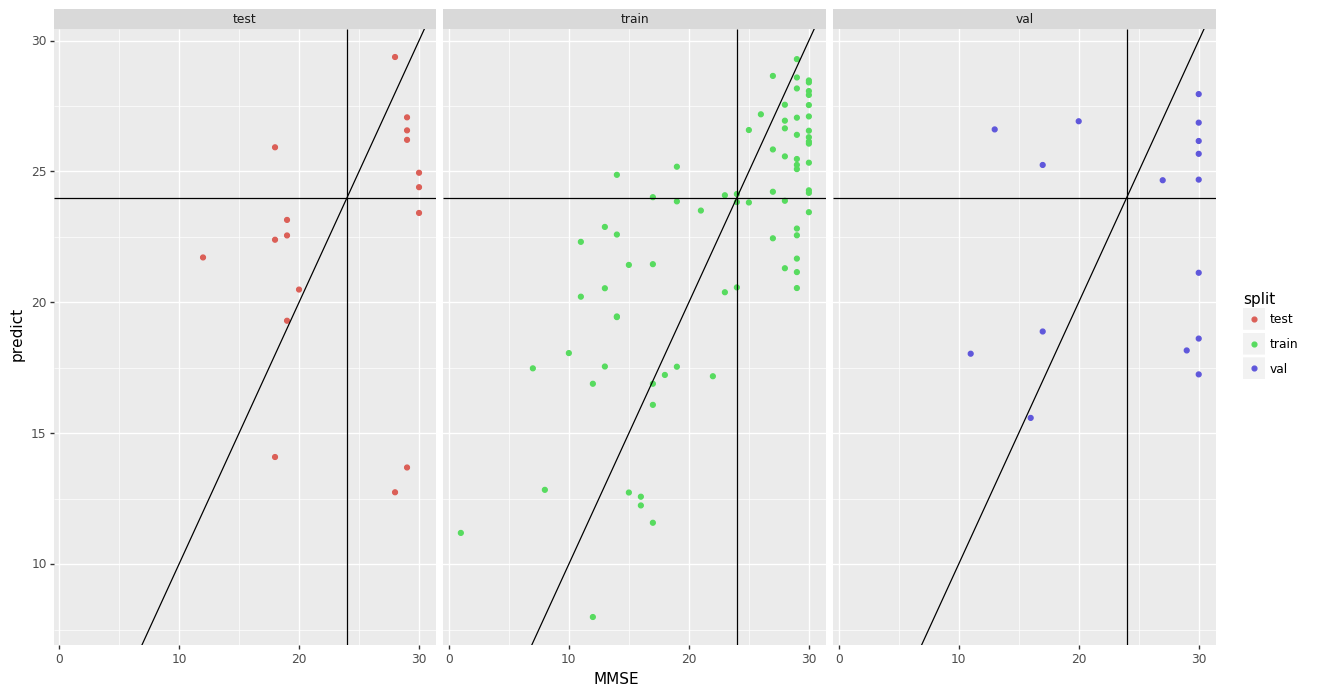

<ggplot: (-9223363255831778153)>

In [26]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

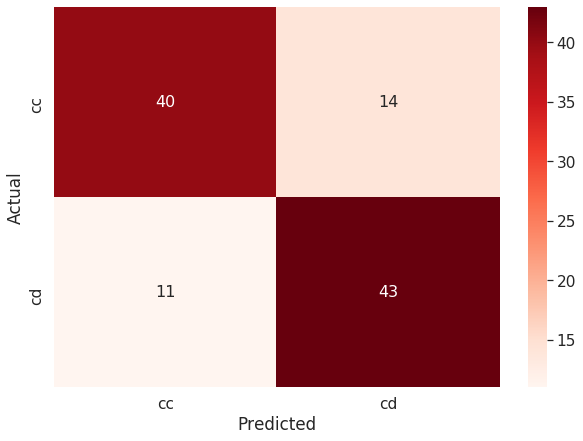

In [27]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [30]:
model.save('saved_model/base_line/20210222')

INFO:tensorflow:Assets written to: saved_model/base_line/20210222/assets


In [29]:
ls saved_model/base_line

20210210/  20210217/  20210222/
